# HW09: ML Support for Judge Decision-Making

In [1]:
import pandas as pd

# Data Prep

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv')
df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [3]:
df.columns

Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event', 'two_year_recid'],
      dtype='object')

In [4]:
df['days_from_recid'] = pd.to_datetime(df['r_offense_date']) - pd.to_datetime(df['c_offense_date'])
df['days_from_recid'] = df['days_from_recid'].dt.days
df['two_year_recid2'] = df['days_from_recid']<=730
df['two_year_recid2'] = df['two_year_recid2'].astype(int)

In [5]:
d = pd.get_dummies(df['c_charge_degree'])
df = pd.concat([df, d], axis=1)
df.head()
df = df.rename(columns={'F':'c_charge_degreeF'})
df = df.rename(columns={'M':'c_charge_degreeM'})
d = pd.get_dummies(df['age_cat'])
df = pd.concat([df, d], axis=1)
df = df.rename(columns={'25 - 45':'age_cat_25 - 45'})
df = df.rename(columns={'Greater than 45':'age_cat_Greater than 45'})
df = df.rename(columns={'Less than 25':'age_cat_Less than 25'})
d = pd.get_dummies(df['race'])
df = pd.concat([df, d], axis=1)
d = pd.get_dummies(df['sex'])
df = pd.concat([df, d], axis=1)
d = pd.get_dummies(df['score_text'])
df = pd.concat([df, d], axis=1)
df = df.rename(columns={'High':'score_text_high'})
df = df.rename(columns={'Medium':'score_text_medium'})
df = df.rename(columns={'Low':'score_text_low'})

In [6]:
df['male'] = (df['sex'] == 'Male').astype(int)
df['felony'] = (df['c_charge_degree'] == 'F').astype(int)

In [7]:
# judge decision
df['jailed'] = df['c_jail_in'].notna().astype(int)
D = df['jailed']
D.value_counts()

1    6907
0     307
Name: jailed, dtype: int64

In [8]:
# ML outcome
Y = df['two_year_recid2'] 
Y.value_counts()

0    4557
1    2657
Name: two_year_recid2, dtype: int64

In [9]:
# predictors
predictors = ['felony',
              'male', 'age', 
              'juv_fel_count','juv_misd_count', 'juv_other_count', 'priors_count']
X = df[predictors]
X.describe()

,felony,male,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count
count,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000
mean,0.646798,0.806626,34.817993,0.067230,0.090934,0.109371,3.472415
std,0.477998,0.394971,11.888922,0.473972,0.485239,0.501586,4.882538
min,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,25.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,31.000000,0.000000,0.000000,0.000000,2.000000
75%,1.000000,1.000000,42.000000,0.000000,0.000000,0.000000,5.000000
max,1.000000,1.000000,96.000000,20.000000,13.000000,17.000000,38.000000


# Predict Recidivism from Features

Use your preferred machine learning approach to predict recidivism from defendant features. Use nested training/test split so we can get clean test-set predictions for the whole dataset (see Lecture 6 Slide 9).

In [29]:
# perform nested train/test split 
from sklearn.model_selection import train_test_split

seed = 349856

a_x, b_x, a_y, b_y, a_d, b_d = train_test_split(X, Y, D, test_size=0.5, random_state=seed)
train_a_x, test_a_x, train_a_y, test_a_y = train_test_split(a_x, a_y, test_size=0.2, random_state=seed)
train_b_x, test_b_x, train_b_y, test_b_y = train_test_split(b_x, b_y, test_size=0.2, random_state=seed)

# train a model in each training set to predict recidism (Y) from predictors (X)
from xgboost import XGBClassifier

a_xgbc = XGBClassifier(random_state = seed, eval_set = [test_a_x, test_a_y], early_stopping_rounds = 10)
a_xgbc.fit(train_a_x, train_a_y)

b_xgbc = XGBClassifier(random_state = seed, eval_set = [test_b_x, test_b_y], early_stopping_rounds = 10)
b_xgbc.fit(train_b_x, train_b_y)

# form clean test-set predictions for recidivism in the full dataset
pred_a_y = b_xgbc.predict(a_x)
pred_b_y = a_xgbc.predict(b_x)
prob_a_y = b_xgbc.predict_proba(a_x)
prob_b_y = a_xgbc.predict_proba(b_x)

pred_y = np.hstack((pred_a_y, pred_b_y))
pred_d = np.hstack((a_d, b_d))

[16:39:46] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { early_stopping_rounds, eval_set } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:39:46] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { early_stopping_rounds, eval_set } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




Evaluate test set performance.

A-set Accuracy:                              0.642084835042972
B-set Accuracy:                              0.6456889381757693
A-set Balanced Accuracy:                     0.5937276074511826
B-set Balanced Accuracy:                     0.5833407629746302
A-set Receiver Operating Characteristic AUC: 0.6315662224513809
B-set Receiver Operating Characteristic AUC: 0.6390883334819262
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
[0.2620689655172414, 0.24781849912739964, 0.2860103626943005, 0.3453815261044177, 0.41397849462365593, 0.47333333333333333, 0.505338078291815, 0.5730337078651685, 0.68, 0.5285714285714286]


(0.0, 1.0)

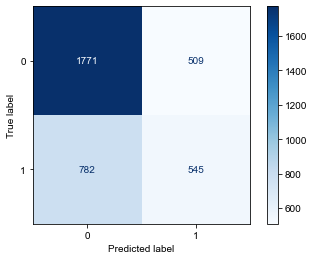

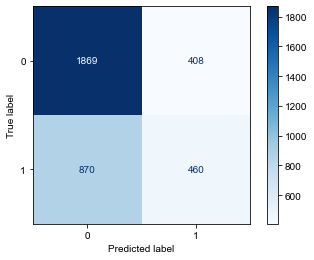

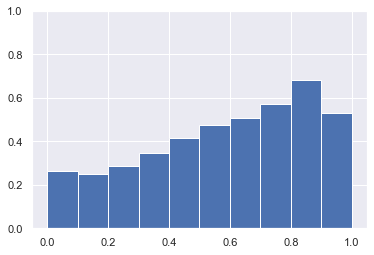

In [11]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, f1_score, confusion_matrix, plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# show a confusion matrix
a_cf = confusion_matrix(a_y,pred_a_y)
plot_confusion_matrix(b_xgbc, a_x, a_y, cmap='Blues')

b_cf = confusion_matrix(b_y,pred_b_y)
plot_confusion_matrix(a_xgbc, b_x, b_y, cmap='Blues')

# compute accuracy, balanced accuracy, and roc_auc
print("A-set Accuracy:                              {}".format(accuracy_score(a_y,pred_a_y)))
print("B-set Accuracy:                              {}".format(accuracy_score(b_y,pred_b_y)))
print("A-set Balanced Accuracy:                     {}".format(balanced_accuracy_score(a_y,pred_a_y)))
print("B-set Balanced Accuracy:                     {}".format(balanced_accuracy_score(b_y,pred_b_y)))
print("A-set Receiver Operating Characteristic AUC: {}".format(roc_auc_score(a_y,prob_a_y[:,1])))
print("B-set Receiver Operating Characteristic AUC: {}".format(roc_auc_score(b_y,prob_b_y[:,1])))

# produce a regplot or calibration plot, plotting true rates on vertical axis against predictions on horizontal axis
bins  = []
probability = []
for i in range(10):
    bins.append(i/10)
    probability.append(a_y[(i/10 <= prob_a_y[:,1]) & (prob_a_y[:,1] < i/10 + 0.1)].mean())

sns.set_theme()
plt.figure()
print(bins)
print(probability)
plt.bar(bins, probability, width=0.1, align='edge')
plt.ylim([0,1])

_(Optional)_ Interpret the model predictions _(this is week 12 material)_

In [12]:
# identify predictive features. 
# e.g. with logistic regression, show features with largest coefficients. with xgboost, show feature importance.
# TODO (optional)

# Analyze Judge Decisions

Do judges jail according to recidivism risk?

<AxesSubplot:ylabel='jailed'>

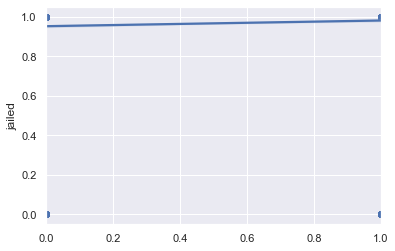

In [13]:
# produce a regplot with judge decision (D) on vertical axis and predicted recidivism probability (Yhat) on horizontal axis.
sns.regplot(x = pred_a_y, y = a_d)

# Build a Robot Judge

In [20]:
# average recidivism of released under human judges:
Y[D==0].mean()

0.08469055374592833

In [15]:
# average recidivism of jailed under human judges:
Y[D==1].mean()

0.3809179093673085

In [31]:
# predicted recidivism under human judges, for those released
pred_y[pred_d==0].mean() 

0.16612377850162866

In [30]:
# predicted recidivism under human judges, for those jailed
pred_y[pred_d==1].mean() 

0.27088460981612855

In [32]:
# N = number of defendants that judges jail.
N = D.sum()
N

6907

In [51]:
# sort dataset by increasing Y-hat (predicted recidivism)
sorted_pred_y = np.sort(pred_y)

# assign jail to the N riskiest defendants
Dstar = np.hstack((np.zeros(len(pred_y)-N), np.ones(N)))

[0 0 0 ... 1 1 1]


In [52]:
# predicted recidivism under machine judges, for those released
pred_y[Dstar==0].mean() 

0.0

In [53]:
# predicted recidivism under machine judges, for those jailed
pred_y[Dstar==1].mean() 

0.27826842333864193

_(Optional)_ Analyze differences between the robot and human judge (when D ≠ D*). What types of defendants do they disagree about?

In [ ]:
# visualize differences in X when D != Dstar
# e.g., regress features that predict difference
# or train a model to predict divergence and show feature importance ranks. (optional)
# TODO

# (Optional) Predict Judge Decisions from Features

Use your preferred machine learning approach to predict the judge's jailing decision from defendant features. 

In [ ]:
# train a model in each training set to predict jail (D) from predictors (X)
# TODO

# form clean test-set predictions for decision in the full dataset
# TODO

Evaluate test set performance.

In [ ]:
# show a confusion matrix
# TODO

# compute accuracy, balanced accuracy, and roc_auc
# TODO

# produce a calibration plot
# TODO

Interpret the model predictions.  _(optional, as this is week 12 material)_

In [ ]:
# identify predictive features. (as above)
# TODO (optional)

# Compare to the predictive features from the previous section, and discuss any differences
# TODO (optional)